In [1]:
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

from astropy.time import Time
from astropy import units as u

In [3]:
radial_acc = pd.read_excel('hd_to_hip_map.xlsx')

for i in radial_acc.index:
    rv_data = pd.read_csv('%s_RV.dat'%radial_acc.loc[i,'hd_id'],sep='\t')
    rv_data.columns = ['BJD','RV','RVErr']
    rv_data['Year'] = rv_data['BJD'].apply(lambda x: (
        Time(x, format='jd') - Time(rv_data['BJD'][0],format='jd')).sec/31557600)
    res_wls = sm.WLS(rv_data['RV'], sm.add_constant(rv_data['Year'])
                     , weights=1./(rv_data['RVErr'] ** 2)).fit()
    radial_acc.loc[i,'aRV'] = res_wls.params[1]
    radial_acc.loc[i,'aRV_Err'] = res_wls.bse[1]


In [6]:
radial_acc.columns

Index(['hd_id', 'hip_id', 'separation', 'sep_er_plus', 'sep_er_min',
       'c_msini_jup', 'c_msini_er_jup', 'sep_source', 'aRV', 'aRV_Err'],
      dtype='object')

In [22]:
#import pandas as pd
#from astropy import units as u
from f_calc_astrometric_acceleration import calc_astrometric_acceleration

def calc_astrometric_acceleration_wrapper(row):

    # for acceleration calculation and converts to Astropy units
    pmrahip = row['pmra_hip']*u.mas/u.yr #mas/yr
    pmragaia = row['pmra_gaia']*u.mas/u.yr #mas/yr
    pmrahg = row['pmra_hg']*u.mas/u.yr #mas/yr
    
    pmdechip = row['pmdec_hip']*u.mas/u.yr #mas/yr
    pmdecgaia = row['pmdec_gaia']*u.mas/u.yr #mas/yr
    pmdechg = row['pmdec_hg']*u.mas/u.yr #mas/yr

    rahipepoch = row['epoch_ra_hip']*u.yr #yr
    ragaiaepoch = row['epoch_ra_gaia']*u.yr #yr
    dechipepoch = row['epoch_dec_hip']*u.yr #yr
    decgaiaepoch = row['epoch_ra_gaia']*u.yr #yr
    
    plx = (row['parallax_gaia'])*u.mas #parallax in mas
    d = plx.to(u.parsec, equivalencies=u.parallax())
    plx_error = row['parallax_gaia_error']*u.mas
    d_error = plx_error.to(u.parsec, equivalencies=u.parallax())
    
    pmragaia_error = row['pmra_gaia_error']*u.mas/u.yr
    pmdecgaia_error = row['pmdec_gaia_error']*u.mas/u.yr
    pmrahg_error = row['pmra_hg_error']*u.mas/u.yr
    pmdechg_error = row['pmdec_hg_error']*u.mas/u.yr
    pmrahip_error = row['pmra_hip_error']*u.mas/u.yr
    pmdechip_error = row['pmdec_hip_error']*u.mas/u.yr

    error_numerator_one = (pmdecgaia - pmdechg)**2 * (pmdecgaia_error**2 
                                                      + pmdechg_error**2)
    error_denominator_one = (1/d)**2 * (((decgaiaepoch - dechipepoch)**2 
                                         + (ragaiaepoch - rahipepoch)**2)/2) * (
        (pmdecgaia - pmdechg)**2 + (pmragaia - pmrahg)**2)
    error_numerator_two = (pmragaia - pmrahg)**2 * (pmragaia_error**2 + pmrahg_error**2)
    error_denominator_two = error_denominator_one
    error_numerator_three = ((pmdecgaia - pmdechg)**2 + (pmragaia - pmrahg)**2
                            ) * (1/d_error)**2
    error_denominator_three = (1/d)**4 * (((decgaiaepoch - dechipepoch)**2 + (
        ragaiaepoch - rahipepoch)**2)/2)

    astrometric_acc_error_sq = 4*((error_numerator_one/error_denominator_one) + (error_numerator_two/error_denominator_two) + (error_numerator_three/error_denominator_three))
    astrometric_acc_error = np.sqrt(astrometric_acc_error_sq)
    # Acc Error
    astrometric_acc_error_cu = astrometric_acc_error.to(u.m /u.second/u.yr, equivalencies=u.dimensionless_angles())

    #calls function "f_calc_astrometric_acceleration", a script that
    #contains the acceleration calculation


    #executes the acceleration calculation function
    return [calc_astrometric_acceleration(plx,
                                      pmrahip,
                                      pmragaia,
                                      pmrahg,
                                      pmdechip,
                                      pmdecgaia,
                                      pmdechg,
                                      rahipepoch,
                                      ragaiaepoch,
                                      dechipepoch,
                                      decgaiaepoch),astrometric_acc_error_cu]

# downloads data: Brandt Hipparcos-Gaia Catalog of Accelerations
filename = 'Full-Catalog_WDS-HIRES-New-Chisq.csv'
catalog = pd.read_csv(filename)
catalog = catalog[catalog.hip_id.isin(list(radial_acc.hip_id.unique()))].copy()
catalog['acc_astrom'] = catalog.apply(calc_astrometric_acceleration_wrapper,axis=1) #axis 1 means apply by row, rather tahn axis 0, by columns
catalog['acc_astrom_error'] = catalog['acc_astrom'].map(lambda x: x[1])
catalog['acc_astrom'] = catalog['acc_astrom'].map(lambda x: x[0])
catalog = catalog.merge(radial_acc,on='hip_id')
catalog['aRV'] = catalog['aRV'].map(lambda x: x*u.m/u.second/u.yr)
catalog['aRV_Err'] = catalog['aRV_Err'].map(lambda x: x*u.m/u.second/u.yr)
catalog['separation'] = catalog['separation'].map(lambda x: x*u.AU)
catalog['sep_er_plus'] = catalog['sep_er_plus'].map(lambda x: x*u.AU)
catalog['sep_er_min'] = catalog['sep_er_min'].map(lambda x: x*u.AU)
catalog['c_msini_jup'] = catalog['c_msini_jup'].map(lambda x: x*u.Mjup)
catalog['c_msini_er_jup'] = catalog['c_msini_er_jup'].map(lambda x: x*u.Mjup)
catalog = catalog[['hip_id','hd_id','separation', 'sep_er_plus','sep_er_min','c_msini_jup',
                   'c_msini_er_jup', 'sep_source','acc_astrom','acc_astrom_error','aRV',
                   'aRV_Err',]].copy()

In [23]:
#solarMass = 2*10**30 #kg
G = ((6.67408*10**-11)*u.m**3/u.kg/u.second**2).to(u.AU**3/u.Mjup/u.second**2)
catalog['mass/r2'] = catalog.apply(lambda x: ((x['acc_astrom'].to(u.AU/u.second**2)**2 + 
                                               x['aRV'].to(u.AU/u.second**2)**2)**(3/2)) / 
                                   (G*x['acc_astrom'].to(u.AU/u.second**2)**2),axis=1)

catalog['mass/r2 error'] = catalog.apply(lambda x: np.sqrt(
    (9*x['aRV']**2*x['aRV_Err']**2/(x['aRV']**2+x['acc_astrom']**2)**2
             + (3*x['acc_astrom']*x['acc_astrom_error']/(x['aRV']**2+x['acc_astrom']**2)
               - 2*x['acc_astrom_error']/x['acc_astrom'])**2)*x['mass/r2']**2),axis=1)

In [24]:
catalog['mass'] = catalog.apply(lambda x: x['mass/r2']*x['separation']**2, axis=1)
catalog['mass error'] = catalog.apply(lambda x: np.sqrt( 
    (4*x['sep_er_plus']**2/x['separation']**2 + 
     9*x['aRV']**2*x['aRV_Err']**2/(x['aRV']**2+x['acc_astrom']**2)**2
             + (3*x['acc_astrom']*x['acc_astrom_error']/(x['aRV']**2+x['acc_astrom']**2)
               - 2*x['acc_astrom_error']/x['acc_astrom'])**2)*x['mass']**2),axis=1)

In [25]:
catalog.columns

Index(['hip_id', 'hd_id', 'separation', 'sep_er_plus', 'sep_er_min',
       'c_msini_jup', 'c_msini_er_jup', 'sep_source', 'acc_astrom',
       'acc_astrom_error', 'aRV', 'aRV_Err', 'mass/r2', 'mass/r2 error',
       'mass', 'mass error'],
      dtype='object')

In [26]:
catalog = catalog [['hip_id', 'hd_id', 'mass', 'mass error', 'separation', 'sep_er_plus', 'sep_er_min', 'c_msini_jup',
       'c_msini_er_jup', 'sep_source', 'acc_astrom', 'acc_astrom_error', 'aRV',
       'aRV_Err', 'mass/r2', 'mass/r2 error']]
catalog

,hip_id,hd_id,mass,mass error,separation,sep_er_plus,sep_er_min,c_msini_jup,c_msini_er_jup,sep_source,acc_astrom,acc_astrom_error,aRV,aRV_Err,mass/r2,mass/r2 error
0,30480,HD45701,960.6587868369903 jupiterMass,55.578337118830326 jupiterMass,22.28 AU,0.57 AU,0.58 AU,1034.0 jupiterMass,87.0 jupiterMass,Kane2019,327.23328573878194 m / (s yr),1.4702230340726299 m / (s yr),-63.210481216336916 m / (s yr),15.640907081493244 m / (s yr),1.935257621372249 jupiterMass / AU2,0.05225457651732673 jupiterMass / AU2
1,52472,HD92987,130.76121822686594 jupiterMass,16.37842787520641 jupiterMass,9.75 AU,0.61 AU,0.59 AU,17.9 jupiterMass,2.4 jupiterMass,Kane2019,244.38383472429578 m / (s yr),1.3773525634234363 m / (s yr),-14.78755189656275 m / (s yr),0.9954671612820352 m / (s yr),1.3755289228335668 jupiterMass / AU2,0.007734344737760662 jupiterMass / AU2
2,79578,HD145825,92.62149333407453 jupiterMass,11.963006481639589 jupiterMass,7.33 AU,0.2 AU,0.21 AU,108.0 jupiterMass,6.2 jupiterMass,Kane2019,154.36230471463222 m / (s yr),1.9965754605251123 m / (s yr),118.04046264187726 m / (s yr),12.482300992950337 m / (s yr),1.7238672917940723 jupiterMass / AU2,0.20180613221518637 jupiterMass / AU2
3,110649,HD212330,9766.752104129862 jupiterMass,1059.7820572545334 jupiterMass,16.21 AU,0.48 AU,0.47 AU,673.0 jupiterMass,33.0 jupiterMass,Kane2019,105.98102026234601 m / (s yr),2.3692306354183716 m / (s yr),407.367807501406 m / (s yr),11.804948065185917 m / (s yr),37.16927884794712 jupiterMass / AU2,3.3795254219816173 jupiterMass / AU2
4,114699,HD219077,125.05890821009913 jupiterMass,156.63747208652129 jupiterMass,7.03 AU,0.2 AU,0.21 AU,13.4 jupiterMass,0.78 jupiterMass,Kane2019,2.201052201684368 m / (s yr),1.3420308611076197 m / (s yr),12.79833094445112 m / (s yr),1.9833129590690357 m / (s yr),2.5304862560191967 jupiterMass / AU2,3.166186005835689 jupiterMass / AU2
5,116250,HD221420,47.23901411728918 jupiterMass,11.886497458633736 jupiterMass,18.5 AU,2.3 AU,2.3 AU,9.7 jupiterMass,1.1 jupiterMass,Kane2019,17.640933157570426 m / (s yr),1.5994655723318343 m / (s yr),-8.822307158691387 m / (s yr),0.1943343475352107 m / (s yr),0.1380248768949282 jupiterMass / AU2,0.00532565503472266 jupiterMass / AU2


Text(0, 0.5, '$M_2/r^2 (M_{\\odot}/AU^2)$')

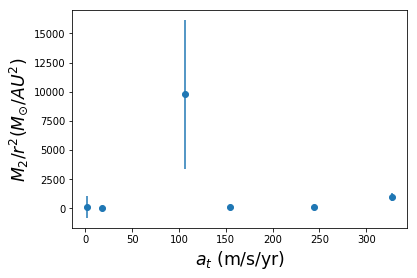

In [21]:
plt.errorbar(catalog['acc_astrom'].map(lambda x: x.value),
            catalog['mass'].map(lambda x: x.value),
           yerr = 6*catalog['mass error'].map(lambda x: x.value),fmt='o')
plt.xlabel('$a_t$ (m/s/yr)', fontsize='xx-large')
plt.ylabel('$M_2/r^2 (M_{\odot}/AU^2)$', fontsize='xx-large')

In [ ]:
r = np.logspace(-2, 3, num=1000,base=10)*u.au
m2_r2 = catalog.loc[0,'mass/r2']*r**2
m2_r2_error = catalog.loc[0,'mass/r2 error']*r**2
plt.errorbar(r.value,m2_r2.value,yerr=6*m2_r2_error.value)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$r^2$', fontsize='xx-large')
plt.xlabel('$M_2$', fontsize='xx-large')

In [ ]:
m2_r2_error.value